
*Note:* You can run this from your computer (Jupyter or terminal), or use one of the
hosted options:
[![binder-logo](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ploomber/binder-env/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fploomber%252Fprojects%26urlpath%3Dlab%252Ftree%252Fprojects%252Fspec-api-python%252FREADME.ipynb%26branch%3Dmaster)
[![deepnote-logo](https://deepnote.com/buttons/launch-in-deepnote-small.svg)](https://deepnote.com/launch?template=deepnote&url=https://github.com/ploomber/projects/blob/master/spec-api-python/README.ipynb)


# Your first Python pipeline

This tutorial will guide you to run your first pipeline with Ploomber.

## Setup (skip if using deepnote or binder)

Get code (run in a terminal):

~~~sh
git clone https://github.com/ploomber/projects
cd projects/spec-api-python
~~~

Install dependencies:

~~~sh
conda env create --file environment.yaml
conda activate spec-api-python
~~~

## Description

This pipeline contains 3 tasks, the first task `get.py` gets some data,
`clean.py` cleans it and `plot.py` generates a visualization:

In [1]:
%%sh
ls *.py

clean.py
plot.py
raw.py


*Note:* Each task in the pipeline is a Python script, but you can also use notebooks as tasks.

Along with the `*.py` files, there is a `pipleine.yaml` file where we declare
which files we want to use as pipeline tasks:

In [2]:
%%sh
cat pipeline.yaml

tasks:
  - source: raw.py
    name: raw

  - source: clean.py
    name: clean

  - source: plot.py
    name: plot


The `pipeline.yaml` file is optional, but it gives you more flexibility.
[Click here](https://github.com/ploomber/projects/tree/master/spec-api-directory) to see an example without a `pipeline.yaml` file.

That's all we need. Let's plot the pipeline:

In [3]:
%%sh
# Note: plotting doesn't work in deepnote
ploomber plot

Plot saved at: pipeline.png


100%|██████████| 3/3 [00:00<00:00, 4125.54it/s]


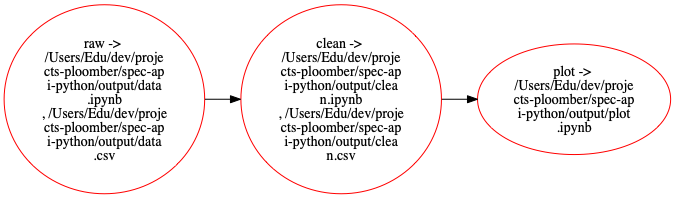

In [4]:

from IPython.display import Image
Image(filename='pipeline.png')

With can also get a pipeline summary with the `status` command:

In [5]:
%%sh
ploomber status

name    Last run      Outdated?      Product          Doc (short)    Location
------  ------------  -------------  ---------------  -------------  ----------
raw     Has not been  Source code    {'nb': File(/Us                 raw.py
        run                          ers/Edu/dev/pro
                                     jects-
                                     ploomber/spec-
                                     api-python/outp
                                     ut/data.ipynb),
                                     'data': File(/U
                                     sers/Edu/dev/pr
                                     ojects-
                                     ploomber/spec-
                                     api-python/outp
                                     ut/data.csv)}
clean   Has not been  Source code &  {'nb': File(/Us                 clean.py
        run           Upstream       ers/Edu/dev/pro
                                     jects-
                             

100%|██████████| 3/3 [00:00<00:00, 4225.29it/s]


## How is execution order determined?

Rather than requiring you to explicitly declare tasks, dependencies, Ploomber
exracts them from your code. For example, to clean the data, we must get it
first, hence, we declare the following in `clean.py`:

~~~python
# get data first
upstream = ['raw']
~~~

Second, we must declare where to save the output of each task, we do so through
a `product` variable:

~~~python
product = {'nb': 'output/clean.ipynb', 'data': 'output/clean.csv'}
~~~

We have two products here, the clean data and a notebook. Scripts and notebook
automatically generate an output notebook so you can easily embed charts and
tables. This is useful when your analysis requires some visual feedback,
instead of writing code to save tables/charts you can leverage the Jupyter
notebook format which supports this.

## Building the pipeline

Let's build the pipeline:

In [6]:
%%sh
mkdir output
ploomber build

name    Ran?      Elapsed (s)    Percentage
------  ------  -------------  ------------
raw     True          2.31333       34.9486
clean   True          1.5494        23.4077
plot    True          2.75649       41.6437


Building task "plot": 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]


This pipeline saves all the output in the `output/` directory, we have a few
data files:

In [7]:
%%sh
ls output/*.csv

output/clean.csv
output/data.csv


And a notebook for each script:

In [8]:
%%sh
ls output/*.ipynb

output/clean.ipynb
output/data.ipynb
output/plot.ipynb


## Updating the pipeline

Quick experimentation is essential to develop a data pipeline. Ploomber allows
you to quickly run new experiments without having to keep track of tasks
dependencies.

Let's say you found a problematic column in the data and want to add more
cleaning logic to your `clean.py` script. `raw.py` does not depend
on `clean.py` (it's actually the other way around), but `plot.py` does. If
you modify `clean.py`, you'd have to execute `clean.py` and then `plot.py`
to bring your pipeline up-to-date.

As your pipeline grows in number of tasks keeping track of task dependencies
get very time-consuming. Automatic dependency tracking guarantees that
your tasks are using the up-to-date inputs without having to re-execute all tasks in your pipeline again.

Make some changes to the `clean.py` script, then build again:

In [9]:
%%sh
ploomber build

name    Ran?      Elapsed (s)    Percentage
------  ------  -------------  ------------
raw     False               0             0
clean   False               0             0
plot    False               0             0


100%|██████████| 3/3 [00:00<00:00, 2730.07it/s]
0it [00:00, ?it/s]


You'll see that `raw.py` didn't run because it was not affected by the change!

## Where to go from here

* This tutorial showed how to build a pipeline with Ploomber, [the next
tutorial](https://ploomber.readthedocs.io/en/stable/get-started/basic-concepts.html) goes deeper in terms of concepts and the Ploomber's design rationale.
* For a more complete example, take a look at the [ml-basic/](https://github.com/ploomber/projects/tree/master/ml-basic) example, which builds a Machine Learning pipeline where some of the tasks are Python functions (instead of scripts).
* The [spec-api-sql/](https://github.com/ploomber/projects/tree/master/spec-api-sql) example shows a pipeline where data manipulation starts in a SQL
database, then data is downloaded and visualized using Python.
* Using a `pipeline.yaml` file is a convenient way to write your workflows and is
often enough for a lot of projects. However, if you need more flexibility, you
can use the Python API directly, see the [python-api/](https://github.com/ploomber/projects/tree/master/python-api) example.
*  If you use R, take a look a the [spec-api-r/](https://github.com/ploomber/projects/tree/master/spec-api-r) example, which contains a similar
pipeline to this but using R.

In [10]:
# Parameters
product = "spec-api-python/README.ipynb"
